In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.4 MB/s eta 0:00:00


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests as gct
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from google.colab import drive

In [3]:
# Import pmdarima library
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from statistics import mean
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/blockchain'
os.chdir(path)

Mounted at /content/drive/


### 1. Our CSVs

In [5]:
blocks = pd.read_csv('./blocks.csv')
blocks

,block_number,date_time,size,gas_limit,gas_used,transaction_count
0,13432144,2021-10-17 00:00,137337,30000000,29989466,395
1,13432145,2021-10-17 00:00,152246,30000000,29991025,350
2,13432146,2021-10-17 00:00,86607,30000000,18441422,182
3,13432147,2021-10-17 00:01,25291,29970705,5773702,44
4,13432148,2021-10-17 00:01,131885,29999972,26063490,337
...,...,...,...,...,...,...
5512332,18944476,2024-01-05 23:59,78795,30000000,29997771,177
5512333,18944477,2024-01-05 23:59,76583,30000000,15833654,168
5512334,18944478,2024-01-05 23:59,98769,30000000,11467724,113
5512335,18944479,2024-01-05 23:59,192081,30000000,16086918,114


In [6]:
trans = pd.read_csv('./transcations.csv')
trans

,block_number,date_time,total_volume
0,13432144,2021-10-17 00:00,683.326345
1,13432145,2021-10-17 00:00,199.728254
2,13432146,2021-10-17 00:00,3046.571869
3,13432147,2021-10-17 00:01,142.073001
4,13432148,2021-10-17 00:01,320.793757
...,...,...,...
5452703,18944476,2024-01-05 23:59,44.329264
5452704,18944477,2024-01-05 23:59,58.734846
5452705,18944478,2024-01-05 23:59,8.849958
5452706,18944479,2024-01-05 23:59,16.469168


In [7]:
df = pd.merge(blocks, trans, on=['block_number','date_time'], how='left')
df

,block_number,date_time,size,gas_limit,gas_used,transaction_count,total_volume
0,13432144,2021-10-17 00:00,137337,30000000,29989466,395,683.326345
1,13432145,2021-10-17 00:00,152246,30000000,29991025,350,199.728254
2,13432146,2021-10-17 00:00,86607,30000000,18441422,182,3046.571869
3,13432147,2021-10-17 00:01,25291,29970705,5773702,44,142.073001
4,13432148,2021-10-17 00:01,131885,29999972,26063490,337,320.793757
...,...,...,...,...,...,...,...
5512332,18944476,2024-01-05 23:59,78795,30000000,29997771,177,44.329264
5512333,18944477,2024-01-05 23:59,76583,30000000,15833654,168,58.734846
5512334,18944478,2024-01-05 23:59,98769,30000000,11467724,113,8.849958
5512335,18944479,2024-01-05 23:59,192081,30000000,16086918,114,16.469168


In [8]:
df.dtypes

block_number           int64
date_time             object
size                   int64
gas_limit              int64
gas_used               int64
transaction_count      int64
total_volume         float64
dtype: object

In [9]:
df.fillna(0, inplace=True)
df.sort_values(by='block_number', inplace=True)
#df.drop(columns='block_number', inplace=True)
df['date_time'] = pd.to_datetime(blocks['date_time'].str[:16])
#df.set_index('date_time', inplace=True)
#by_day = df.resample('D').mean()
#by_day.columns = ['avg_size','avg_gas_limit','avg_gas_used','avg_transaction_count', 'avg_transferred_eth']

In [10]:
# 1-period lag
df['gas_used_lag1'] = df['gas_used'].shift(1)
df['transaction_count_lag1'] = df['transaction_count'].shift(1)

# rolling average of the past 7 days
df['avg_gas_used_rolling6'] = df['gas_used'].rolling(window=7).mean()
df['vg_transaction_count_rolling6'] = df['transaction_count'].rolling(window=7).mean()

df.dropna(inplace=True)

In [11]:
#NOT SURE IF WILL RUN THIS:
df.reset_index(inplace=True)
#df.rename(columns={'index': 'date_time'}, inplace=True)
df

,index,block_number,date_time,size,gas_limit,gas_used,transaction_count,total_volume,gas_used_lag1,transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6
0,6,13432150,2021-10-17 00:01:00,13154,30000000,3193107,37,43.293353,5015664.0,67.0,1.692398e+07,201.714286
1,7,13432151,2021-10-17 00:01:00,44641,30029295,12217034,104,45.052822,3193107.0,37.0,1.438506e+07,160.142857
2,8,13432152,2021-10-17 00:01:00,120699,30058619,5772869,59,60.503657,12217034.0,104.0,1.092533e+07,118.571429
3,9,13432153,2021-10-17 00:02:00,133983,30087972,30083202,288,353.318960,5772869.0,59.0,1.258844e+07,133.714286
4,10,13432154,2021-10-17 00:02:00,57667,30058591,14529821,98,43.438204,30083202.0,288.0,1.383931e+07,141.428571
...,...,...,...,...,...,...,...,...,...,...,...,...
5512326,5512332,18944476,2024-01-05 23:59:00,78795,30000000,29997771,177,44.329264,12647111.0,128.0,1.633361e+07,145.857143
5512327,5512333,18944477,2024-01-05 23:59:00,76583,30000000,15833654,168,58.734846,29997771.0,177.0,1.707900e+07,152.714286
5512328,5512334,18944478,2024-01-05 23:59:00,98769,30000000,11467724,113,8.849958,15833654.0,168.0,1.631579e+07,142.285714
5512329,5512335,18944479,2024-01-05 23:59:00,192081,30000000,16086918,114,16.469168,11467724.0,113.0,1.666343e+07,138.428571


In [12]:
start_date = '2023-12-21'
end_date = '2023-12-31'

filtered_df = df[(df['date_time'] >= start_date) & (df['date_time'] <= end_date)]

filtered_df

,index,block_number,date_time,size,gas_limit,gas_used,transaction_count,total_volume,gas_used_lag1,transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6
5398384,5398390,18830534,2023-12-21 00:00:00,202810,30000000,18745989,229,654.386071,17500063.0,137.0,1.583575e+07,144.142857
5398385,5398391,18830535,2023-12-21 00:00:00,106720,30000000,25036241,278,428.313937,18745989.0,229.0,1.684016e+07,170.000000
5398386,5398392,18830536,2023-12-21 00:00:00,115533,30000000,22918795,239,162.235422,25036241.0,278.0,1.914398e+07,188.857143
5398387,5398393,18830537,2023-12-21 00:00:00,116365,30000000,18768759,239,138.407539,22918795.0,239.0,2.034702e+07,205.285714
5398388,5398394,18830538,2023-12-21 00:00:00,52306,30000000,10110416,152,161.600530,18768759.0,239.0,1.935035e+07,205.857143
...,...,...,...,...,...,...,...,...,...,...,...,...
5469607,5469613,18901757,2023-12-30 23:59:00,312295,30000000,22010000,196,33.721717,7501449.0,111.0,1.444948e+07,144.714286
5469608,5469614,18901758,2023-12-31 00:00:00,126030,30000000,29987906,381,1518.138154,22010000.0,196.0,1.635706e+07,181.714286
5469609,5469615,18901759,2023-12-31 00:00:00,253139,30000000,14452860,153,14.377223,29987906.0,381.0,1.646045e+07,183.142857
5469610,5469616,18901760,2023-12-31 00:00:00,150123,30000000,11270787,143,215.175499,14452860.0,153.0,1.576278e+07,179.714286


In [13]:
#In order to predict tomorrow we need to lag it such that we can have tomorrow's gas used in today's row
filtered_df['gas_used_tom'] = filtered_df['gas_used'].shift(-1)
filtered_df.dropna(inplace=True)
filtered_df

<ipython-input-13-96ca487a70fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['gas_used_tom'] = filtered_df['gas_used'].shift(-1)
<ipython-input-13-96ca487a70fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(inplace=True)


,index,block_number,date_time,size,gas_limit,gas_used,transaction_count,total_volume,gas_used_lag1,transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,gas_used_tom
5398384,5398390,18830534,2023-12-21 00:00:00,202810,30000000,18745989,229,654.386071,17500063.0,137.0,1.583575e+07,144.142857,25036241.0
5398385,5398391,18830535,2023-12-21 00:00:00,106720,30000000,25036241,278,428.313937,18745989.0,229.0,1.684016e+07,170.000000,22918795.0
5398386,5398392,18830536,2023-12-21 00:00:00,115533,30000000,22918795,239,162.235422,25036241.0,278.0,1.914398e+07,188.857143,18768759.0
5398387,5398393,18830537,2023-12-21 00:00:00,116365,30000000,18768759,239,138.407539,22918795.0,239.0,2.034702e+07,205.285714,10110416.0
5398388,5398394,18830538,2023-12-21 00:00:00,52306,30000000,10110416,152,161.600530,18768759.0,239.0,1.935035e+07,205.857143,10560534.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5469606,5469612,18901756,2023-12-30 23:59:00,38900,30000000,7501449,111,21.903143,13692488.0,161.0,1.341035e+07,139.142857,22010000.0
5469607,5469613,18901757,2023-12-30 23:59:00,312295,30000000,22010000,196,33.721717,7501449.0,111.0,1.444948e+07,144.714286,29987906.0
5469608,5469614,18901758,2023-12-31 00:00:00,126030,30000000,29987906,381,1518.138154,22010000.0,196.0,1.635706e+07,181.714286,14452860.0
5469609,5469615,18901759,2023-12-31 00:00:00,253139,30000000,14452860,153,14.377223,29987906.0,381.0,1.646045e+07,183.142857,11270787.0


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


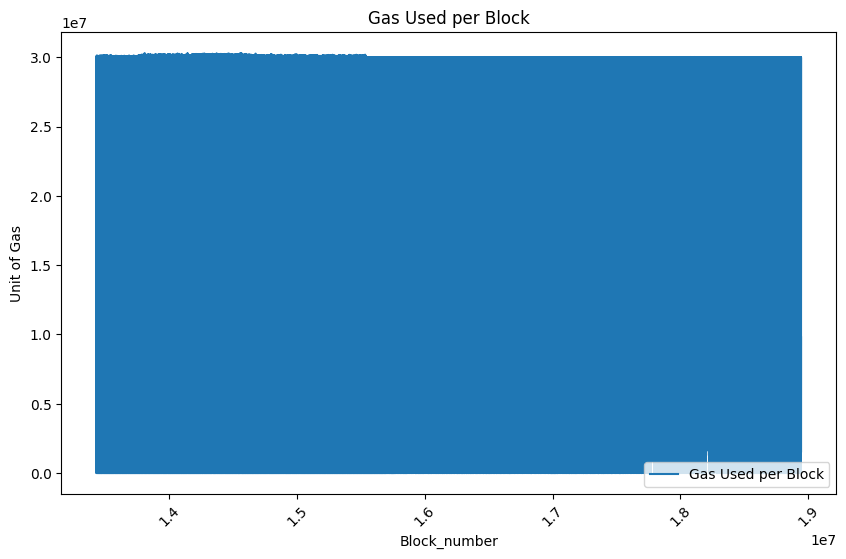

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df['block_number'], df['gas_used'], label='Gas Used per Block')  # Assuming date_time is the index
plt.title('Gas Used per Block')
plt.xlabel('Block_number')
plt.ylabel('Unit of Gas')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [15]:
df.columns

Index(['index', 'block_number', 'date_time', 'size', 'gas_limit', 'gas_used',
       'transaction_count', 'total_volume', 'gas_used_lag1',
       'transaction_count_lag1', 'avg_gas_used_rolling6',
       'vg_transaction_count_rolling6'],
      dtype='object')

In [16]:
df = df.drop('date_time', axis=1)

In [17]:
filtered_df.columns

Index(['index', 'block_number', 'date_time', 'size', 'gas_limit', 'gas_used',
       'transaction_count', 'total_volume', 'gas_used_lag1',
       'transaction_count_lag1', 'avg_gas_used_rolling6',
       'vg_transaction_count_rolling6', 'gas_used_tom'],
      dtype='object')

In [18]:
filtered_df.dtypes

index                                     int64
block_number                              int64
date_time                        datetime64[ns]
size                                      int64
gas_limit                                 int64
gas_used                                  int64
transaction_count                         int64
total_volume                            float64
gas_used_lag1                           float64
transaction_count_lag1                  float64
avg_gas_used_rolling6                   float64
vg_transaction_count_rolling6           float64
gas_used_tom                            float64
dtype: object

In [19]:
filtered_df= filtered_df.drop('date_time', axis=1)

In [20]:
filtered_df.isna().sum()

index                            0
block_number                     0
size                             0
gas_limit                        0
gas_used                         0
transaction_count                0
total_volume                     0
gas_used_lag1                    0
transaction_count_lag1           0
avg_gas_used_rolling6            0
vg_transaction_count_rolling6    0
gas_used_tom                     0
dtype: int64

## At the Block Level

## Linear Regression Using Back Test and SciKitLearn

In [22]:
#Using Scikitlearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

window_size = 30

actuals_lr = []
predictions_lr = []
diff_lr = []
mse_lst_lr = []
mape_lst_lr = []

# Loop through the DataFrame
for t in range(window_size, len(filtered_df)):
    # Define the training window
    train = filtered_df.iloc[t - window_size:t-1] # t-1

    # The independent variables (features) should exclude the target variable 'gas_used_tom'
    X_train = train.drop(columns=['gas_used_tom'])
    y_train = train['gas_used_tom']

    # Create and fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Prepare X_test for the next day, ensuring it is 2D and has the same structure as X_train
    test_features = filtered_df.iloc[t]  # Get the features for day t
    test_features = test_features.drop(labels=['gas_used_tom'])  # Drop the target variable
    X_test = pd.DataFrame([test_features])  # Make it 2D

    # Predict the next day's gas_used_tom
    pred = model.predict(X_test)[0]
    # Store the actual and predicted values
    actual = filtered_df['gas_used_tom'].iloc[t]
    actuals_lr.append(actual)
    predictions_lr.append(pred)
    diff_lr.append(pred-actual)

    # Calculate performance metrics like MSE and R-squared
    mse = mean_squared_error(actuals_lr, predictions_lr)
    mape = mean_absolute_percentage_error(actuals_lr, predictions_lr)
    mse_lst_lr.append(mse)
    mape_lst_lr.append(mape)

# Now, actuals and predictions hold the actual and predicted values, respectively
mse = mean_squared_error(actuals_lr, predictions_lr)
r2 = r2_score(actuals_lr, predictions_lr)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 3915360704092522.0
R-squared: -163.0327521530096


## XGBoost Model

In [24]:
#With Correct Back Test
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

window_size = 30

actuals_xgb = []
predictions_xgb = []
diff_xgb = []
mse_lst_xgb = []
mape_lst_xgb = []

# Loop through the DataFrame
for t in range(window_size, len(filtered_df-1)):
    # Define the training window
    train = filtered_df.iloc[t - window_size:t-1]

    # The independent variables (features) should exclude the target variable 'avg_gas_used_tom'
    X_train = train.drop(columns=['gas_used_tom'])
    y_train = train['gas_used_tom']

    # Initialize and fit the XGBoost model
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Prepare X_test for the next day, ensuring it has the same structure as X_train
    test_features = filtered_df.iloc[t]  # Get the features for day t
    X_test = test_features.drop(labels=['gas_used_tom']).to_frame().T  # Drop target and convert to DataFrame

    # Predict the next day's avg_gas_used
    pred = model.predict(X_test)[0]

    # Store the actual and predicted values
    actual = filtered_df['gas_used_tom'].iloc[t]
    actuals_xgb.append(actual)
    predictions_xgb.append(pred)
    diff_xgb.append(pred-actual)

    # Calculate performance metrics like MSE and R-squared
    mse = mean_squared_error(actuals_xgb, predictions_xgb)
    mape = mean_absolute_percentage_error(actuals_xgb, predictions_xgb)
    mse_lst_xgb.append(mse)
    mape_lst_xgb.append(mape)

actuals_xgb = actuals_xgb[:-1]
predictions_xgb = predictions_xgb[:-1]

# Calculate performance metrics like MSE and R-squared
mse = mean_squared_error(actuals_xgb, predictions_xgb)
r2 = r2_score(actuals_xgb, predictions_xgb)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 39410373356781.266
R-squared: -0.6510655906792049


## Random Forest

In [25]:
#### With backtest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Adjusting window size to 7 days as requested
window_size = 30

actuals_rf = []
predictions_rf = []
diff_rf = []
mse_lst_rf = []
mape_lst_rf = []

# Loop through the DataFrame
for t in range(window_size, len(filtered_df)-1):
    # Define the training window
    train = filtered_df.iloc[t - window_size:t]

    # The independent variables (features) should exclude the target variable 'avg_gas_used_tom'
    X_train = train.drop(columns=['gas_used_tom'])
    y_train = train['gas_used_tom']

    # Initialize and fit the Random Forest model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Prepare X_test for the next day, ensuring it has the same structure as X_train
    test_features = filtered_df.iloc[t]  # Get the features for day t
    X_test = test_features.drop(labels=['gas_used_tom']).to_frame().T  # Drop target and convert to DataFrame

    # Predict the next day's avg_gas_used
    pred = model.predict(X_test)[0]

    # Store the actual and predicted values
    actual = filtered_df['gas_used_tom'].iloc[t]
    actuals_rf.append(actual)
    predictions_rf.append(pred)
    diff_rf.append(pred-actual)

    # Calculate performance metrics like MSE and R-squared
    mse = mean_squared_error(actuals_rf, predictions_rf)
    mape = mean_absolute_percentage_error(actuals_rf, predictions_rf)
    mse_lst_rf.append(mse)
    mape_lst_rf.append(mape)

actuals_rf = actuals_rf[:-1]
predictions_rf = predictions_rf[:-1]

# Calculate performance metrics like MSE and R-squared
mse = mean_squared_error(actuals_rf, predictions_rf)
r2 = r2_score(actuals_rf, predictions_rf)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 28666881518871.25
R-squared: -0.20096918885714077


## Graphing them relative to each other

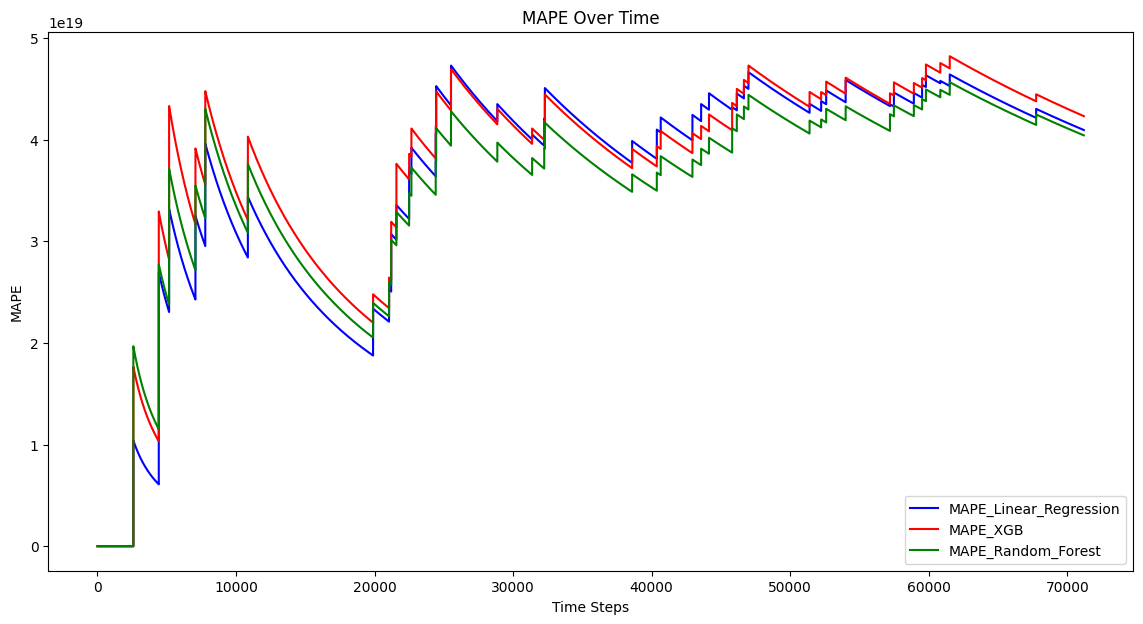

In [26]:
plt.figure(figsize=(14, 7))
plt.plot(mape_lst_lr, label='MAPE_Linear_Regression', color='blue')
plt.plot(mape_lst_xgb, label='MAPE_XGB', color='red')
plt.plot(mape_lst_rf, label='MAPE_Random_Forest', color='green')
plt.title('MAPE Over Time')
plt.xlabel('Time Steps')
plt.ylabel('MAPE')
plt.legend()
plt.show()

In [27]:
print(f'Linear Regression Mean MAPE:{np.mean(mape_lst_lr)}')
print(f'Linear Regression Mean MSE:{np.mean(mse_lst_lr)}')

Linear Regression Mean MAPE:3.648082542429928e+19
Linear Regression Mean MSE:4388269524856187.5


In [28]:
print(f'XGB Mean MAPE:{np.mean(mape_lst_xgb)}')
print(f'XGB Mean MSE:{np.mean(mse_lst_xgb)}')

XGB Mean MAPE:3.798390308759486e+19
XGB Mean MSE:39763534323553.164


In [29]:
print(f'Random Forest Mean MAPE:{np.mean(mape_lst_rf)}')
print(f'Random Forest Mean MSE:{np.mean(mse_lst_rf)}')

Random Forest Mean MAPE:3.5567653789701915e+19
Random Forest Mean MSE:29127625493401.92


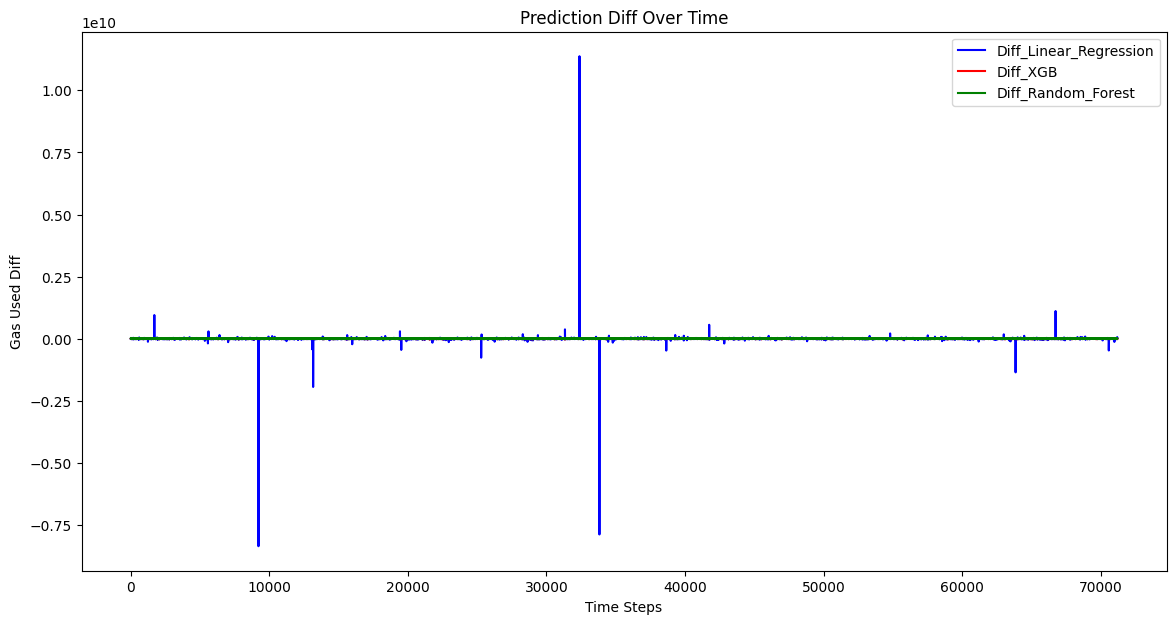

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(diff_lr, label='Diff_Linear_Regression', color='blue')
plt.plot(diff_xgb, label='Diff_XGB', color='red')
plt.plot(diff_rf, label='Diff_Random_Forest', color='green')
plt.title('Prediction Diff Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Gas Used Diff')
plt.legend()
plt.show()

In [31]:
# diff = pred-actural
print(f'Linear Regression Gas Used Diff Avg:{np.mean(diff_lr)}')
print(f'XGB Gas Used Diff Avg:{np.mean(diff_xgb)}')
print(f'Random Forest Gas Used Diff Avg:{np.mean(diff_rf)}')

Linear Regression Gas Used Diff Avg:-104935.55611887907
XGB Gas Used Diff Avg:480576.6425645239
Random Forest Gas Used Diff Avg:360075.3689568234


In [32]:
actuals_lr_percent = [(value - 15000000) / 1200000 for value in actuals_lr]
actuals_xgb_percent = [(value - 15000000) / 1200000 for value in actuals_xgb]
actuals_rf_percent = [(value - 15000000) / 1200000 for value in actuals_rf]

In [33]:
predictions_lr_percent = [(value - 15000000) / 1200000 for value in predictions_lr]
predictions_xgb_percent = [(value - 15000000) / 1200000 for value in predictions_xgb]
predictions_rf_percent = [(value - 15000000) / 1200000 for value in predictions_rf]

In [34]:
diff_lr_percent = [x - y for x, y in zip(predictions_lr_percent, actuals_lr_percent)]

In [35]:
diff_xgb_percent = [x - y for x, y in zip(predictions_xgb_percent, actuals_xgb_percent)]

In [36]:
diff_rf_percent = [x - y for x, y in zip(predictions_rf_percent, actuals_rf_percent)]

In [37]:
# diff = pred-actural
print(f'Linear Regression Base Fee Diff Avg:{np.mean(diff_lr_percent)}%')
print(f'XGB Gas Used Base Fee Diff Avg:{np.mean(diff_xgb_percent)}%')
print(f'Random Forest Base Fee Diff Avg:{np.mean(diff_rf_percent)}%')

Linear Regression Base Fee Diff Avg:-0.08744629676573253%
XGB Gas Used Base Fee Diff Avg:0.40052320644964146%
Random Forest Base Fee Diff Avg:0.30005538798511133%


In [ ]:
##Linear

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

actuals_lr = np.array(actuals_lr)
predictions_lr = np.array(predictions_lr)

# Calculating differences for annotation
differences = predictions_lr - actuals_lr

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals_lr, label='Actuals', marker='o')
plt.plot(predictions_lr, label='Predicted', marker='x')

plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Comparison of Actuals vs Predicted Values for Gas Used Linear Regression')
plt.xticks(ticks=np.arange(len(actuals_lr)), labels=[f'Point {i+1}' for i in range(len(actuals_lr))])
plt.legend()

# Adding text annotations for differences
#for i, (act, pred) in enumerate(zip(actuals, predictions)):
    #plt.text(i, max(act, pred) + 10, f'Diff: {differences[i]}', ha='center')

plt.grid(True)
plt.show()

In [ ]:
## XGBoost

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

actuals_xgb = np.array(actuals_xgb)
predictions_xgb = np.array(predictions_xgb)

# Calculating differences for annotation
differences = predictions_xgb - actuals_xgb

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals_xgb, label='Actuals', marker='o')
plt.plot(predictions_xgb, label='Predicted', marker='x')

plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Comparison of Actuals vs Predicted Values for Gas Used XGBoost')
plt.xticks(ticks=np.arange(len(actuals_xgb)), labels=[f'Point {i+1}' for i in range(len(actuals_xgb))])
plt.legend()

# Adding text annotations for differences
#for i, (act, pred) in enumerate(zip(actuals, predictions)):
    #plt.text(i, max(act, pred) + 10, f'Diff: {differences[i]}', ha='center')

plt.grid(True)
plt.show()

In [ ]:
## Random Forest

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

actuals_rf = np.array(actuals_rf)
predictions_rf = np.array(predictions_rf)

# Calculating differences for annotation
differences = predictions_rf - actuals_rf

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals_rf, label='Actuals', marker='o')
plt.plot(predictions_rf, label='Predicted', marker='x')

plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Comparison of Actuals vs Predicted Values for Gas Used Random Forest')
plt.xticks(ticks=np.arange(len(actuals_rf)), labels=[f'Point {i+1}' for i in range(len(actuals_rf))])
plt.legend()

# Adding text annotations for differences
#for i, (act, pred) in enumerate(zip(actuals, predictions)):
    #plt.text(i, max(act, pred) + 10, f'Diff: {differences[i]}', ha='center')

plt.grid(True)
plt.show()

## Per 20 BlockAvg

In [ ]:
twentydf = filtered_df

In [ ]:
twentydf = twentydf.drop('date_time', axis=1)

In [ ]:

group_labels = np.arange(len(twentydf)) // 20

# Group by these labels and calculate the mean
twentydf = twentydf.groupby(group_labels).mean()

twentydf

##Linear Regression

In [ ]:
#ran on all the days

In [ ]:
#Using Scikitlearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

window_size = 30

actuals_lr = []
predictions_lr = []
diff_lr = []
mse_lst_lr = []
mape_lst_lr = []

# Loop through the DataFrame
for t in range(window_size, len(twentydf)):
    # Define the training window
    train = twentydf.iloc[t - window_size:t-1] # t-1

    # The independent variables (features) should exclude the target variable 'gas_used_tom'
    X_train = train.drop(columns=['gas_used_tom'])
    y_train = train['gas_used_tom']

    # Create and fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Prepare X_test for the next day, ensuring it is 2D and has the same structure as X_train
    test_features = twentydf.iloc[t]  # Get the features for day t
    test_features = test_features.drop(labels=['gas_used_tom'])  # Drop the target variable
    X_test = pd.DataFrame([test_features])  # Make it 2D

    # Predict the next day's gas_used_tom
    pred = model.predict(X_test)[0]
    # Store the actual and predicted values
    actual = twentydf['gas_used_tom'].iloc[t]
    actuals_lr.append(actual)
    predictions_lr.append(pred)
    diff_lr.append(pred-actual)

    # Calculate performance metrics like MSE and R-squared
    mse = mean_squared_error(actuals_lr, predictions_lr)
    mape = mean_absolute_percentage_error(actuals_lr, predictions_lr)
    mse_lst_lr.append(mse)
    mape_lst_lr.append(mape)

# Now, actuals and predictions hold the actual and predicted values, respectively
mse = mean_squared_error(actuals_lr, predictions_lr)
r2 = r2_score(actuals_lr, predictions_lr)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 230613134071.35663
R-squared: 0.5102898152003695


## XGBOOST

In [ ]:
#With Correct Back Test
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Adjusting window size to 7 days as requested
window_size = 30

actuals_xgb = []
predictions_xgb = []
diff_xgb = []
mse_lst_xgb = []
mape_lst_xgb = []

# Loop through the DataFrame
for t in range(window_size, len(twentydf-1)):
    # Define the training window
    train = twentydf.iloc[t - window_size:t-1]

    # The independent variables (features) should exclude the target variable 'avg_gas_used_tom'
    X_train = train.drop(columns=['gas_used_tom'])
    y_train = train['gas_used_tom']

    # Initialize and fit the XGBoost model
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Prepare X_test for the next day, ensuring it has the same structure as X_train
    test_features = twentydf.iloc[t]  # Get the features for day t
    X_test = test_features.drop(labels=['gas_used_tom']).to_frame().T  # Drop target and convert to DataFrame

    # Predict the next day's avg_gas_used
    pred = model.predict(X_test)[0]

    # Store the actual and predicted values
    actual = twentydf['gas_used_tom'].iloc[t]
    actuals_xgb.append(actual)
    predictions_xgb.append(pred)
    diff_xgb.append(pred-actual)

    # Calculate performance metrics like MSE and R-squared
    mse = mean_squared_error(actuals_xgb, predictions_xgb)
    mape = mean_absolute_percentage_error(actuals_xgb, predictions_xgb)
    mse_lst_xgb.append(mse)
    mape_lst_xgb.append(mape)

actuals_xgb = actuals_xgb[:-1]
predictions_xgb = predictions_xgb[:-1]

# Calculate performance metrics like MSE and R-squared
mse = mean_squared_error(actuals_xgb, predictions_xgb)
r2 = r2_score(actuals_xgb, predictions_xgb)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 346647918045.95386
R-squared: 0.26311779114669653


###Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Adjusting window size to 7 days as requested
window_size = 30

actuals_rf = []
predictions_rf = []
diff_rf = []
mse_lst_rf = []
mape_lst_rf = []

# Loop through the DataFrame
for t in range(window_size, len(twentydf)-1):
    # Define the training window
    train = twentydf.iloc[t - window_size:t]

    # The independent variables (features) should exclude the target variable 'avg_gas_used_tom'
    X_train = train.drop(columns=['gas_used_tom'])
    y_train = train['gas_used_tom']

    # Initialize and fit the Random Forest model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Prepare X_test for the next day, ensuring it has the same structure as X_train
    test_features = twentydf.iloc[t]  # Get the features for day t
    X_test = test_features.drop(labels=['gas_used_tom']).to_frame().T  # Drop target and convert to DataFrame

    # Predict the next day's avg_gas_used
    pred = model.predict(X_test)[0]

    # Store the actual and predicted values
    actual = twentydf['gas_used_tom'].iloc[t]
    actuals_rf.append(actual)
    predictions_rf.append(pred)
    diff_rf.append(pred-actual)

    # Calculate performance metrics like MSE and R-squared
    mse = mean_squared_error(actuals_rf, predictions_rf)
    mape = mean_absolute_percentage_error(actuals_rf, predictions_rf)
    mse_lst_rf.append(mse)
    mape_lst_rf.append(mape)

actuals_rf = actuals_rf[:-1]
predictions_rf = predictions_rf[:-1]

# Calculate performance metrics like MSE and R-squared
mse = mean_squared_error(actuals_rf, predictions_rf)
r2 = r2_score(actuals_rf, predictions_rf)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 236779503491.75354
R-squared: 0.49674388644942347


## Graphing them relative to each other

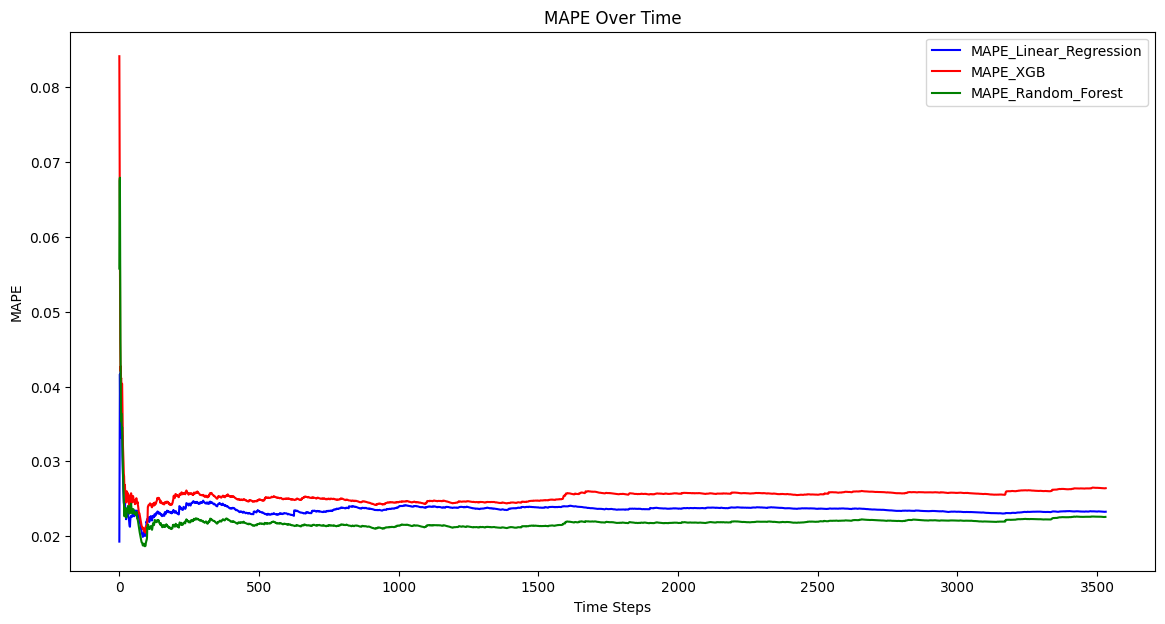

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(mape_lst_lr, label='MAPE_Linear_Regression', color='blue')
plt.plot(mape_lst_xgb, label='MAPE_XGB', color='red')
plt.plot(mape_lst_rf, label='MAPE_Random_Forest', color='green')
plt.title('MAPE Over Time')
plt.xlabel('Time Steps')
plt.ylabel('MAPE')
plt.legend()
plt.show()

In [ ]:
print(f'Linear Regression Mean MAPE:{np.mean(mape_lst_lr)}')
print(f'Linear Regression Mean MSE:{np.mean(mse_lst_lr)}')

Linear Regression Mean MAPE:0.023588481426372435
Linear Regression Mean MSE:245221793061.006


In [ ]:
print(f'XGB Mean MAPE:{np.mean(mape_lst_xgb)}')
print(f'XGB Mean MSE:{np.mean(mse_lst_xgb)}')

XGB Mean MAPE:0.02543701685384094
XGB Mean MSE:283379215435.4538


In [ ]:
print(f'Random Forest Mean MAPE:{np.mean(mape_lst_rf)}')
print(f'Random Forest Mean MSE:{np.mean(mse_lst_rf)}')

Random Forest Mean MAPE:0.021878662467691004
Random Forest Mean MSE:205243748499.58517


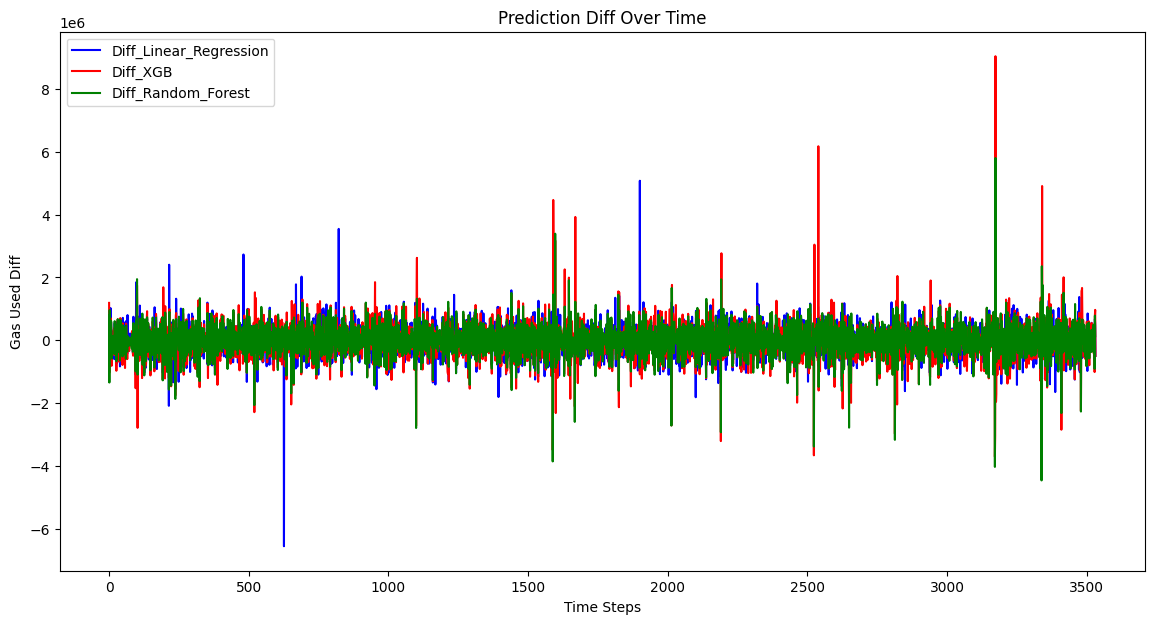

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(diff_lr, label='Diff_Linear_Regression', color='blue')
plt.plot(diff_xgb, label='Diff_XGB', color='red')
plt.plot(diff_rf, label='Diff_Random_Forest', color='green')
plt.title('Prediction Diff Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Gas Used Diff')
plt.legend()
plt.show()

In [ ]:
# diff = pred-actural
print(f'Linear Regression Gas Used Diff Avg:{np.mean(diff_lr)}')
print(f'XGB Gas Used Diff Avg:{np.mean(diff_xgb)}')
print(f'Random Forest Gas Used Diff Avg:{np.mean(diff_rf)}')

Linear Regression Gas Used Diff Avg:-6325.3049223152175
XGB Gas Used Diff Avg:-30208.30675659278
Random Forest Gas Used Diff Avg:-990.5652016420319


In [ ]:
actuals_lr_percent = [(value - 15000000) / 1200000 for value in actuals_lr]
actuals_xgb_percent = [(value - 15000000) / 1200000 for value in actuals_xgb]
actuals_rf_percent = [(value - 15000000) / 1200000 for value in actuals_rf]

In [ ]:
predictions_lr_percent = [(value - 15000000) / 1200000 for value in predictions_lr]
predictions_xgb_percent = [(value - 15000000) / 1200000 for value in predictions_xgb]
predictions_rf_percent = [(value - 15000000) / 1200000 for value in predictions_rf]

In [ ]:
diff_lr_percent = [x - y for x, y in zip(predictions_lr_percent, actuals_lr_percent)]

In [ ]:
diff_xgb_percent = [x - y for x, y in zip(predictions_xgb_percent, actuals_xgb_percent)]

In [ ]:
diff_rf_percent = [x - y for x, y in zip(predictions_rf_percent, actuals_rf_percent)]

In [ ]:
# diff = pred-actural
print(f'Linear Regression Base Fee Diff Avg:{np.mean(diff_lr_percent)}%')
print(f'XGB Gas Used Base Fee Diff Avg:{np.mean(diff_xgb_percent)}%')
print(f'Random Forest Base Fee Diff Avg:{np.mean(diff_rf_percent)}%')

Linear Regression Base Fee Diff Avg:-0.0018170619656093703%
XGB Gas Used Base Fee Diff Avg:0.0031642864310578362%
Random Forest Base Fee Diff Avg:0.0014452575758571455%


In [ ]:
plt.rcParams['figure.figsize'] = [8, 3]

# Let's re-plot Autocorrelation and Partial Autocorrelation
# now graphs make sense some what
utils.plot_acf(avg_gas_used_d1, alpha=.05)
utils.plot_pacf(avg_gas_used_d1 , alpha=.05)

In [ ]:
# Split data
# The total number = 938, train data = 0.8*938≒785
train, test = model_selection.train_test_split(merge['AVG_Unit_of_Gas'], train_size=785)

In [ ]:
# Let's create arema model automatically
arima_model = pm.auto_arima(train,
                            seasonal=True,
                            m=7,
                            d=1,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

In [ ]:
train_pred = arima_model.predict_in_sample()

test_pred, test_pred_ci = arima_model.predict(
    n_periods=test.shape[0],
    return_conf_int=True
)
print('MSE:')
print(mean_squared_error(test, test_pred))
print('RMSE:')
print(np.sqrt(mean_squared_error(test, test_pred)))
print('MAE:')
print(mean_absolute_error(test, test_pred))
print('MAPE:')
print(mean_absolute_percentage_error(test, test_pred))

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]

preds, conf_int95 = arima_model.predict(n_periods=test.shape[0], return_conf_int=True,
                                       alpha=0.05)


# Check the difference between predicted data and actual
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis,test,label="actual",color='black')
plt.plot(x_axis,preds,label="predicted",color='red')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int95[:, 0], conf_int95[:, 1],
                 alpha=0.05, color='b')
plt.legend()
plt.show()

x_axis = np.arange(train.shape[0] + preds.shape[0])
plt.plot(x_axis[:train.shape[0]],train,color='b',label="actual")
plt.plot(x_axis[train.shape[0]:],test,color='b')
plt.plot(x_axis[train.shape[0]:],preds,color='red',label="predicted")
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int95[:, 0], conf_int95[:, 1],
                 alpha=0.05,color='red')
plt.legend()
plt.show()

### 5. Vector AutoRegressive model (use multiple AutoRegressive of each feature)

In [ ]:
plt.rcParams['figure.figsize'] = [6, 4]
merge['AVG_Unit_of_Gas'].diff().dropna().plot()
plt.title('AVG_Unit_of_Gas_diff')

In [ ]:
merge['ETH_USD_price'].diff().dropna().plot()
plt.title('ETH_USD_price')

In [ ]:
merge['Number_of_blocks'].diff().dropna().plot(color = 'red')
plt.title('Number_of_blocks')

In [ ]:
merge['Distinct_miner'].diff().dropna().plot(color = 'orange')
plt.title('Distinct_miner')

In [ ]:
merge['AVG_block_size'].diff().dropna().plot(color = 'purple')
plt.title('AVG_block_size')

In [ ]:
merge['ten_year_real_ir'].diff().dropna().plot(color = 'black')
plt.title('black')

In [ ]:
merge['one_year_real_ir'].diff().dropna().plot(color = 'green')
plt.title('green')

In [ ]:
# drop interest rate because there are too many 0 data
new_merge = merge.drop(columns=['ETH_USD_volume','BTC_USD_price','BTC_USD_volume','Avg_Transaction_Count','ten_year_real_ir','one_year_real_ir',],axis=1)
new_merge

In [ ]:
var_model = VAR(new_merge.diff().dropna())

lag_order = var_model.select_order(maxlags=50)
print(lag_order.summary())

In [ ]:
# Fit the model based on aic
optimal_lag = lag_order.selected_orders['aic']
var_model_fitted = var_model.fit(optimal_lag)

In [ ]:
# Did durbin-watson test
# If each value is between 1.6 and 2.4, this regression is valid
out = durbin_watson(var_model_fitted.resid)

for col, val in zip(new_merge.diff().columns, out):
    print(col, ':', round(val, 2))

In [ ]:
forecast_input = new_merge.diff().values[-optimal_lag:]

forecast_span = 20
fc = var_model_fitted.forecast(y=forecast_input, steps=forecast_span)
new_merge_forecast = pd.DataFrame(fc, index=new_merge.index[-forecast_span:], columns=new_merge.columns + '_1d')

In [ ]:
# To transform the first-order difference model to the original scale
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(new_merge, new_merge_forecast, second_diff=False)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(10,10))
for i, (col,ax) in enumerate(zip(new_merge.columns, axes.flatten())):
    #df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_results[col+'_forecast'].plot(legend=True, ax=ax,grid=True)
    new_merge[col][-forecast_span:].plot(legend=True, ax=ax,grid=True);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)      # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape,'mae': mae,'mpe': mpe,'mse':mse ,'rmse':rmse})

print('Forecast Accuracy of: AVG_Unit_of_Gas')
accuracy_prod = forecast_accuracy(df_results['AVG_Unit_of_Gas_forecast'].values, new_merge.loc['2024-02-10':'2024-02-29','AVG_Unit_of_Gas'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))